Terrawise use the following image data over areas of interest: Dynamic World yearly maps, NDVI, NDSI, RGB.
This notebook generates and displays NDVI, NDSI and RGB based on sentinel-2 data pulled from AWS. It also reads continental-scale SLGA COGs and clips to the aoi for display.


In [10]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import rasterio as rs
from rasterio import plot
from rasterio.features import geometry_window, geometry_mask
from rasterio.plot import reshape_as_raster
from rasterio.windows import transform

import spyndex #spectral indices
"""
By importing the spyndex package, all that needs to be done is assign the bands from the satellite (in this case sentinel-2) to the correct band identifiers. Then call syndex to calculate the right index.
Note spyndex contains at least 250 indices - so it will make things easy re: adding more indices if users request them
note - if we want to add Landsat, MODIS etc. can assign their bands too.
"""

from dash import Dash, html, dcc, callback, Output, Input, dash_table
import dash_bootstrap_components as dbc
import leafmap.foliumap as leafmap
import dash_leaflet
import plotly.express as px

import pystac_client
import stackstac

###temporary:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Sentinel-2 AWS archive
output_dir = 'data/temp'
geom_path = 'data/stac-demo-aoi.geojson'
#geom_path = 'data/marysville-fire-forest-loss-test-area.geojson'


URL = 'https://earth-search.aws.element84.com/v1'
catalog = pystac_client.Client.open(URL)

timerange = '2023-10-01/2023-10-30'
dst_crs = "EPSG:3857"

lon, lat = -105.78, 35.79 #test only 
#import geometries and reproject/ get bounding box
geom = gpd.read_file(geom_path)
centroid = geom.centroid
bbox = geom.geometry.total_bounds.tolist()

print("Geojson geometry:\n\n ",geom)
print("\n Geometry centroid: \n\n", centroid)
print("\nBounding box: \n\n ",bbox)
print("\nSpyndex test: \n\n", spyndex.indices['NDVI'])

#print(spyndex.bands)

Geojson geometry:

                                              geometry
0  POLYGON ((145.36955 -38.17343, 145.36955 -38.1...

 Geometry centroid: 

 0    POINT (145.38231 -38.18170)
dtype: geometry

Bounding box: 

  [145.36954762848688, -38.18996780887601, 145.3950650720538, -38.1734250469396]

Spyndex test: 

 NDVI: Normalized Difference Vegetation Index
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'R']
        * Formula: (N-R)/(N+R)
        * Reference: https://ntrs.nasa.gov/citations/19740022614
        


In [19]:
items = catalog.search(
    bbox=bbox,
    collections=["sentinel-2-l2a"],
    datetime="2023-11-01/2023-11-15"
).item_collection()

stack = stackstac.stack(
    items,
    bounds_latlon = bbox,
    assets = ['blue', 'green','red', 'nir']
    )
lowcloud = stack[stack["eo:cloud_cover"] < 10]

#being a 4 dimension aray is causing probs for rasterio.plot.
#For now, squeezing the time dimension as I've filtered down to a single image.
#TRY: putting in a loop for each time epoch?

lowcloud = lowcloud.squeeze('time')
lowcloud

<xarray.DataArray 'stackstac-988d2ff312c5bfb1ac7a88220f2110be' (band: 4,
                                                                y: 188, x: 228)>
dask.array<getitem, shape=(4, 188, 228), dtype=float64, chunksize=(1, 188, 228), chunktype=numpy.ndarray>
Coordinates: (12/54)
    time                                     datetime64[ns] 2023-11-13T00:17:...
    id                                       <U24 'S2A_55HCT_20231113_0_L2A'
  * band                                     (band) <U5 'blue' 'green' ... 'nir'
  * x                                        (x) float64 3.572e+05 ... 3.594e+05
  * y                                        (y) float64 5.774e+06 ... 5.772e+06
    platform                                 <U11 'sentinel-2a'
    ...                                       ...
    proj:transform                           object {0, 5800000, 300000, 10, ...
    gsd                                      int64 10
    common_name                              (band) <U5 'blue' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.49 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.098 ... 0.145
    epsg                                     int64 32755
Attributes:
    spec:        RasterSpec(epsg=32755, bounds=(357180.0, 5771850.0, 359460.0...
    crs:         epsg:32755
    transform:   | 10.00, 0.00, 357180.00|\n| 0.00,-10.00, 5773730.00|\n| 0.0...
    resolution:  10.0

In [21]:
# Open a dataset (in this case a xarray.DataArray)
snt = spyndex.datasets.open("sentinel")
snt

<xarray.DataArray (band: 4, x: 300, y: 300)>
array([[[ 299,  276,  280, ...,  510,  516,  521],
        [ 287,  285,  284, ...,  503,  476,  469],
        [ 287,  292,  288, ...,  454,  411,  337],
        ...,
        [ 502,  508,  520, ...,  683,  670,  791],
        [ 486,  518,  532, ...,  688,  696,  693],
        [ 486,  506,  515, ...,  659,  671,  664]],

       [[ 469,  446,  466, ...,  695,  711,  728],
        [ 469,  437,  469, ...,  683,  694,  666],
        [ 460,  460,  460, ...,  628,  595,  527],
        ...,
        [ 804,  808,  832, ...,  920,  872, 1023],
        [ 787,  803,  822, ...,  890,  882,  871],
        [ 787,  799,  822, ...,  893,  832,  834]],

       [[ 319,  293,  328, ..., 1054, 1090, 1110],
        [ 327,  318,  345, ..., 1044, 1004,  952],
        [ 339,  355,  323, ...,  922,  784,  652],
        ...,
        [1528, 1516, 1516, ..., 1250, 1246, 1420],
        [1470, 1502, 1498, ..., 1316, 1200, 1162],
        [1394, 1480, 1472, ..., 1288, 1144, 1122]],

       [[2164, 2128, 2206, ..., 1796, 1837, 1816],
        [2110, 2017, 2228, ..., 1795, 1839, 1788],
        [2050, 2112, 2062, ..., 1816, 1789, 1864],
        ...,
        [1910, 1942, 1942, ..., 2105, 1898, 2102],
        [1836, 1874, 1916, ..., 2075, 1792, 1747],
        [1778, 1844, 1870, ..., 2087, 1830, 1675]]])
Coordinates:
  * band     (band) <U3 'B02' 'B03' 'B04' 'B08'
Dimensions without coordinates: x, y

<Axes: title={'center': 'NDVI'}>

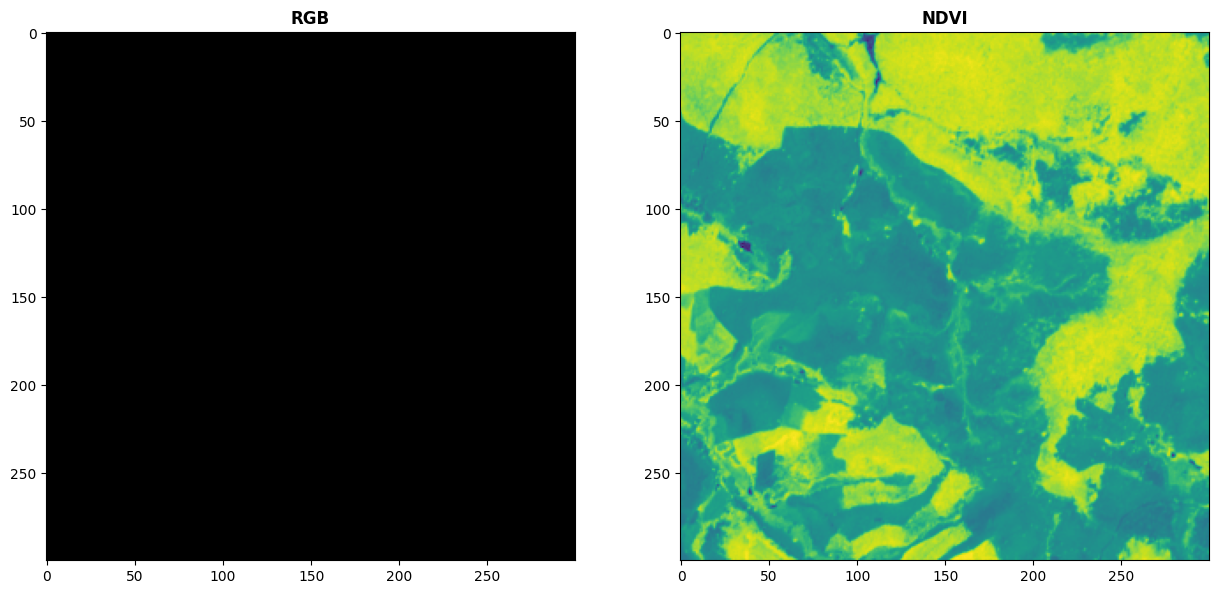

In [26]:
# idx = spyndex.computeIndex(
#     index = ['NDVI', 'GNDVI', 'SAVI'],
#     params = {
#         "G": lowcloud.sel(band = 'green'),
#         "R": lowcloud.sel(band = "red"),
#         "N": lowcloud.sel(band = "nir"),
#         "RE1": lowcloud.sel(band = "rededge1"),
#         "RE2": lowcloud.sel(band = "rededge2"),
#         "RE3": lowcloud.sel(band = "rededge3"),
#         "L": 0.5
#     }
# )


# Scale the data (remember that the valid domain for reflectance is [0,1])
snt = snt / 10000

# Compute the kNDVI and the NDVI for comparison
idx = spyndex.computeIndex(
    index = ["NDVI","kNDVI"],
    params = {
        # Parameters required for NDVI
        "N": snt.sel(band = "B08"),
        "R": snt.sel(band = "B04"),
        # Parameters required for kNDVI
        "kNN" : 1.0,
        "kNR" : spyndex.computeKernel(
            kernel = "RBF",
            params = {
                "a": snt.sel(band = "B08"),
                "b": snt.sel(band = "B04"),
                "sigma": snt.sel(band = ["B08","B04"]).mean("band")
            }),
    }
)


# Plot the indices (and the RGB image for comparison)
fig, ax = plt.subplots(1,2,figsize = (15,15))
plot.show(snt.sel(band = ["B04","B03","B02"]).data / 0.3,ax = ax[0],title = "RGB")
plot.show(idx.sel(index = "NDVI").data,ax = ax[1],title = "NDVI")


In [5]:
# Open a dataset (in this case a pandas.DataFrame)
df = spyndex.datasets.open("spectral")
df


,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,ST_B10,class
0,0.089850,0.100795,0.132227,0.165764,0.269054,0.306206,0.251949,297.328396,Urban
1,0.073859,0.086990,0.124404,0.160979,0.281264,0.267596,0.217917,297.107934,Urban
2,0.072938,0.086028,0.120994,0.140203,0.284220,0.258384,0.200098,297.436064,Urban
3,0.087733,0.103916,0.135981,0.163976,0.254479,0.259580,0.216735,297.203638,Urban
4,0.090593,0.109306,0.150350,0.181260,0.269535,0.273234,0.219554,297.097680,Urban
...,...,...,...,...,...,...,...,...,...
115,0.018048,0.021540,0.040927,0.034438,0.287822,0.113253,0.053742,289.624179,Vegetation
116,0.015325,0.019203,0.044750,0.029900,0.281608,0.101510,0.048325,289.108058,Vegetation
117,0.014830,0.018460,0.035785,0.026242,0.239615,0.088942,0.040845,288.974755,Vegetation
118,0.013620,0.017497,0.032512,0.028030,0.167703,0.071013,0.033997,289.596835,Vegetation


<Figure size 1500x1500 with 0 Axes>

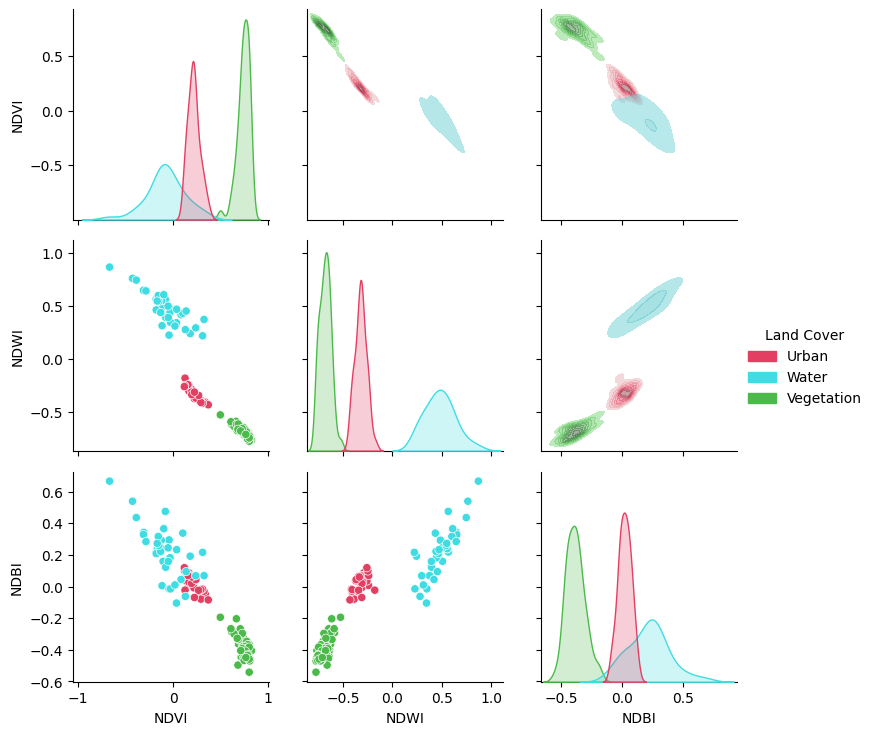

In [6]:

# Compute the desired spectral indices
idx = spyndex.computeIndex(
    index = ["NDVI","NDWI","NDBI"],
    params = {
        "N": df["SR_B5"],
        "R": df["SR_B4"],
        "G": df["SR_B3"],
        "S1": df["SR_B6"]
    }
)

# Add the land cover column to the result
idx["Land Cover"] = df["class"]

# Create a color palette for plotting
colors = ["#E33F62","#3FDDE3","#4CBA4B"]

# Plot a pairplot to check the indices behaviour
plt.figure(figsize = (15,15))
g = sns.PairGrid(idx,hue = "Land Cover",palette = sns.color_palette(colors))
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot,fill = True,alpha = .5)
g.map_diag(sns.kdeplot,fill = True)
g.add_legend()
plt.show()

In [ ]:
# # Perform STAC filtering to get Sentinel-2 data
# try:
#     catalog = pystac_client.Client.open(sentinel_search_url)
#     results = catalog.search(
#         max_items=3,
#         bbox=bbox,
#         datetime=timerange,
#         query={"eo:cloud_cover": {"lt": 50}},
#         collections=["sentinel-2-l2a"]
#     ).item_collection()
# except pystac_client.exceptions.APIError as e:
#     print(f"Error querying STAC API: {e}")

# print(results[0])

In [ ]:
# for item in results:
#     # Process each STAC item and calculate NDVI
#     raster_crs = 'epsg:' + str(item.properties['proj:epsg'])
#     polygon_gdf = geom.to_crs(str(raster_crs))
#     #read in bands needed for indices:

#     rgb_href = item.assets['visual'].href

#     coastal_href = item.assets['coastal'].href #60m band not 10m
#     blue_href = item.assets['blue'].href
#     green_href = item.assets['green'].href
#     red_href = item.assets['red'].href

#     redge1_href = item.assets['redge1'].href #20m
#     redge2_href = item.assets['redge2'].href #20m
#     redge3_href = item.assets['redge3'].href #20m

#     nir_href = item.assets['nir'].href #nir1 band, 10m
#     nir08_href = item.assets['nir08'].href #nir2 20m
#     nir09_href = item.assets['nir09'].href #nir3 60m

#     swir1_href = item.assets['swir16'].href
#     swir2_href = item.assets['swir22'].href

#     with rs.open(nir_href) as nir_src, rs.open(red_href) as red_src:
#         for feature in polygon_gdf.iterfeatures(show_bbox=True):
#             window = geometry_window(nir_src, [feature["geometry"]])
#             window_transform = transform(window, nir_src.transform)
#             window_shape = (window.height, window.width)
            

#             # Read all the data in the window, masking out any NoData
#             nir = nir_src.read(window=window, masked=True).astype('float32')
#             red = red_src.read(window=window, masked=True).astype('float32')

#             # Update the NoData mask to exclude anything outside the polygon
#             mask = geometry_mask([feature["geometry"]], window_shape, window_transform)
#             nir.mask += mask
#             red.mask += mask

#             # Calculate NDVI
#             ndvi = (nir - red) / (nir + red)

#             # Save the masked NDVI to one tif per polygon
#             ndvi_path = '/tmp/stac-ndvi.tif'

#             meta = nir_src.meta

#             meta.update({"driver": "GTiff", 
#                             "dtype": ndvi.dtype, 
#                             "height": window.height, 
#                             "width":window.width, 
#                             "transform": window_transform,
#                             "count":1})
            
#             with rs.open(output_dir + '/test-ndvi.tif', 'w', **meta) as dst:
#                 dst.write(ndvi)

#             ndvi_s3key = 'stac-ndvi.tif'